In [1]:
import torch, torchvision
import os
import random
import dataset_all_annotations as dataset
import metrics
import time

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import loss_fn_multiclass as loss_fn
from unet import UNET

In [2]:
def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold
    
def stack_masks(masks, batch, classes, size=(512,512)):
    stacks = []
    tr = transforms.ToTensor()
    m_size = masks.shape
    #print(masks.shape)
    for b in range(m_size[0]):
        #print("B:", b)
        m = np.zeros(size)
        m = tr(m)
        for c in range(m_size[1]):
            #print("C:", c)
            m = torch.where(m==0, masks[b,c,:,:]*(c+1),m)
        m = m.squeeze()
        stacks.append(m)
    
    stacks = tuple(stacks)
    stacks = torch.stack(stacks, 0)
    return stacks

def validate(model, validation_loader, transform, DEVICE):
    model.eval()
    with torch.no_grad():
        val_loss = []
        for images, masks, names in validation_loader:
            images = transform(images)
            outputs = model(images.to(DEVICE))
            #outputs = untransform(outputs)

            masks = masks.type(torch.LongTensor)
            masks = transform(masks)
            masks = torch.squeeze(masks, 1)
            masks = stack_masks(masks, cst.BATCH_SIZE, 25, size=(512,512))

            vloss = criterion(outputs, masks.to(torch.int64).to(DEVICE))
            loss = vloss.detach().item()
            val_loss.append(loss)

        loss = np.mean(val_loss)
        # print("Validation loss before training: {}".format(loss))
    return loss

def train(model, training_loader, transforms, DEVICE, criterion, optimiser):
    model.train()
    train_loss = []
    for images, masks, names in training_loader:
        images = transform(images)
        outputs = model(images.to(DEVICE))
        #outputs = untransform(outputs)

        masks = masks.type(torch.LongTensor)
        masks = transform(masks)
        masks = torch.squeeze(masks, 1)
        masks = stack_masks(masks, cst.BATCH_SIZE, 25, size=(512,512))

        tloss = criterion(outputs, masks.to(torch.int64).to(DEVICE))
        loss = tloss.detach().item()
        train_loss.append(loss)

        optimiser.zero_grad()
        tloss.backward()
        optimiser.step()

    loss = np.mean(train_loss)
    return loss

def evaluate(eval_model, testing_loader):
    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []

    eval_model.eval()
    for image, mask, name in testing_loader:
        prediction = predict_img(eval_model, transform(image), DEVICE, untransform, out_threshold=cst.THRESHOLD)
        pred = torch.from_numpy(prediction)

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))
    return precisions, recalls, F1s, IOUs

In [3]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

TERMS = ["p"]
SIZE = (384, 512)
FOLDS = [0]    # 0 to 4 only a few folds at a time here for computational resources limit

DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

Starting term: p
Starting fold: 0
125
Training set length: 84
125
Validation set length: 21
125
Testing set length: 20
Loss used: Focal
Epoch: 1
Validation: 101.79570134480794.
Best validation: 101.79570134480794.
Epoch: 2
Validation: 101.43583170572917.
Best validation: 101.43583170572917.
Epoch: 3
Validation: 101.08918126424153.
Best validation: 101.08918126424153.
Epoch: 4
Validation: 100.78871663411458.
Best validation: 100.78871663411458.
Epoch: 5
Validation: 100.66330973307292.
Best validation: 100.66330973307292.
Epoch: 6
Validation: 100.54517491658528.
Best validation: 100.54517491658528.
Epoch: 7
Validation: 100.52655537923177.
Best validation: 100.52655537923177.
Epoch: 8
Validation: 100.50945281982422.
Best validation: 100.50945281982422.
Epoch: 9
Validation: 100.46764500935872.
Best validation: 100.46764500935872.
Epoch: 10
Validation: 100.45563379923503.
Best validation: 100.45563379923503.
Epoch: 11
Validation: 100.51359176635742.
Best validation: 100.45563379923503.
Epoc

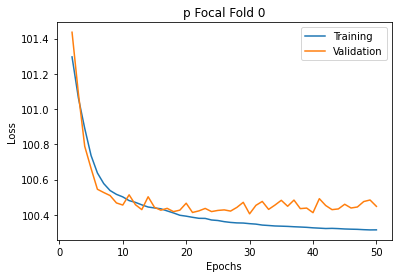

RuntimeError: The size of tensor a (4976832) must match the size of tensor b (119443968) at non-singleton dimension 0

In [4]:
for TERM in TERMS:
    print("Starting term: " + TERM)
    start_term = time.time()
    
    image_folder = "/notebooks/images"
    mask_folder = "/notebooks/" + TERM
    
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])
    
    fold_validation = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_IOU = []
    
    for fold in FOLDS:
        print("Starting fold: {}".format(fold))
        start_fold = time.time()
        """Datasets and loaders"""
        training_set = dataset.ZebrafishDataset(image_folder,
                                                      mask_folder,
                                                      actual_fold=fold,
                                                      dataset="train",
                                                      folds=cst.FOLDS)
        validation_set = dataset.ZebrafishDataset(image_folder,
                                                        mask_folder,
                                                        actual_fold=fold,
                                                        dataset="validate",
                                                        folds=cst.FOLDS)
        testing_set = dataset.ZebrafishDataset(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="test",
                                                     folds=cst.FOLDS)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)
        
        model = UNET(3, 25)
        model.to(DEVICE)
        best_model = UNET(3, 25)
        best_model = model
        
        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Loss used: Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("Loss used: IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Loss used: Tversky":
            print("Loss used: Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"
        if cst.LOSS == "Focal":
            print("Loss used: Focal")
            criterion = loss_fn.FocalLoss(alpha=0.8, gamma= 2, reduction="mean")
            criterion_string = "Focal"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)
        
        """Computing validation loss before training"""
        loss = validate(model, validation_loader, transform, DEVICE)
            
        best_val = loss
        best_epoch = 0
        last_epoch = 0
        
        epochs_train_losses = []
        epochs_val_losses = []
        for epoch in range(cst.EPOCHS):
            # Training
            loss = train(model, training_loader, transforms, DEVICE, criterion, optimiser)
            epochs_train_losses.append(loss)

            """Validation"""
            loss = validate(model, validation_loader, transform, DEVICE)
            epochs_val_losses.append(loss)

            # Updating best model
            if loss < best_val:
                best_val = loss
                best_model = model
                best_epoch = epoch+1

            if (epoch+1)%1 == 0:
                print("Epoch: " + str(epoch+1))
                print("Validation: {}.".format(loss))
                print("Best validation: {}.".format(best_val))
                    
            """Train and validate loops over"""
            curr = time.time()
            curr = curr - start_term
            secondes = curr % 60
            minutes = (curr-secondes)/60
            
            last_epoch = epoch
            
            # Notebooks shutdown after 6 hours. Stop the code and save the results.
            if minutes >= 350:
                break
            if (epoch - best_epoch) >= 50:
                break
            
        """All epochs are over"""
        fold_validation.append(best_val)
        
        model_name = TERM + '_' + cst.LOSS + "_Fold_" + str(fold) + "_Epoch_" + str(best_epoch) + "_MaxEpochs_" 
        model_name += str(cst.EPOCHS) + '_' + cst.OPTIMIZER + "_LR_" + str(cst.LEARNING_RATE) + ".pth"
        
        model_filepath = os.path.join(cst.MODEL, model_name)
        torch.save(best_model.state_dict(), model_filepath)
        
        # Plot losses
        index = [i+1 for i in range(last_epoch+1)]
        plt.plot(index[1:], epochs_train_losses[1:], label="Training")
        plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
        plt.title(TERM + " " + str(cst.LOSS) + " Fold " + str(fold)) 
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()
        
        """Evaluating"""
        precisions, recalls, F1s, IOUs = evaluate(best_model, testing_loader)
        
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1 = np.mean(F1s)
        mean_IOU = np.mean(IOUs)
        
        fold_precision.append(mean_precision)
        fold_recall.append(mean_recall)
        fold_f1.append(mean_f1)
        fold_IOU.append(mean_IOU)
        
        confidence = 0.9
        
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60
        #print("--------------------")
        print("Last epoch: {}".format(last_epoch))
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Fold took: " + str(minutes) + " minutes " + str(secondes) + " seconds to train")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print()
        print("Precision: {}".format(mean_precision))
        print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(precisions), np.max(precisions))
        print()

        print("Recall: {}".format(mean_recall))
        print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(recalls), np.max(recalls))
        print()

        print("F1/Dice score: {}".format(mean_f1))
        print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(F1s), np.max(F1s))
        print()

        print("IoU: {}".format(mean_IOU))
        print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(IOUs), np.max(IOUs))
        print()
        print("--------------------")
    """Fold loop end"""
    print()
    print("ALL FOLDS TRAINING ENDED")
    print("Mean best validation: {}".format(np.mean(fold_validation)))
    print("Mean precision: {}".format(np.mean(fold_precision)))
    print("Mean recall: {}".format(np.mean(fold_recall)))
    print("Mean F1: {}".format(np.mean(fold_f1)))
    print("Mean IOU: {}".format(np.mean(fold_IOU)))
"""term loop end"""
print()

In [ ]:
best_model.eval()
for image, mask, name in testing_loader:
    print("a",end=" ")
image = transform(image)
output = best_model(image.to(DEVICE))
print()
predictions = torch.nn.functional.softmax(output, dim=1)
print(predictions.shape)
pred_labels = torch.argmax(predictions, dim=1)
print(pred_labels.shape)
plt.imshow(pred_labels.cpu().squeeze())
plt.show()

a a a a a a a a a a a a a a a a a a a a 
torch.Size([1, 25, 512, 512])
torch.Size([1, 512, 512])
